In [38]:
import numpy as np
import math
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix, lil_matrix, dok_matrix, coo_matrix, issparse, eye
from scipy.sparse.linalg import eigsh, eigs
from scipy.special import factorial
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed
import itertools
from collections import defaultdict
from functools import lru_cache
from itertools import combinations, product
#from quspin.basis import spin_basis_1d, spin_basis_general
#import tenpy as tp

In [39]:
'''
# ---- spin-1 single-site ops ----
def spin1_operators(dtype=np.complex128):
    Sx = (1/np.sqrt(2)) * np.array([[0, 1, 0],
                                    [1, 0, 1],
                                    [0, 1, 0]], dtype=dtype)
    Sy = (1/np.sqrt(2)) * np.array([[0, -1j, 0],
                                    [1j,  0, -1j],
                                    [0,  1j, 0]], dtype=dtype)
    Sz = np.array([[ 1, 0, 0],
                   [ 0, 0, 0],
                   [ 0, 0,-1]], dtype=dtype)
    return Sx, Sy, Sz

# ---- embeddings ----
def embed_one(L, site, A, d, dtype=np.complex128):
    I = eye(d, dtype=dtype, format='csr')
    op = None
    for s in range(L):
        factor = csr_matrix(A) if s == site else I
        op = factor if op is None else kron(op, factor, format='csr')
    return op

def embed_two(L, i, j, A, B, d, dtype=np.complex128):
    # Handle case where i > j (e.g., periodic boundary wrapping)
    if i > j:
        i, j = j, i
        A, B = B, A
    assert 0 <= i < j < L
    I = eye(d, dtype=dtype, format='csr')
    op = None
    for s in range(L):
        if s == i:   factor = csr_matrix(A)
        elif s == j: factor = csr_matrix(B)
        else:        factor = I
        op = factor if op is None else kron(op, factor, format='csr')
    return op

# ---- H = H_XY + h∑Sz + D∑Sz^2 + J3∑ (3rd-nn XY) ----
def hamiltonian_spin1_xy_plus_H3(L, J=1.0, h=0.0, D=0.0, J3=0.0, bc='open', dtype=np.complex128):
    d = 3
    Sx, Sy, Sz = spin1_operators(dtype=dtype)
    H = csr_matrix((d**L, d**L), dtype=dtype)

    # NN XY
    nn_pairs = [(i, i+1) for i in range(L-1)]
    if bc == 'periodic' and L > 1:
        nn_pairs.append((L-1, 0))
    for i, j in nn_pairs:
        H += J * embed_two(L, i, j, Sx, Sx, d=d, dtype=dtype)
        H += J * embed_two(L, i, j, Sy, Sy, d=d, dtype=dtype)

    # 3rd-NN XY
    if J3 != 0.0 and L >= 4:
        if bc == 'open':
            pairs3 = [(i, i+3) for i in range(L-3)]
        elif bc == 'periodic':
            pairs3 = [(i, (i+3) % L) for i in range(L)]
        else:
            raise ValueError("bc must be 'open' or 'periodic'")
        for i, j in pairs3:
            H += J3 * embed_two(L, i, j, Sx, Sx, d=d, dtype=dtype)
            H += J3 * embed_two(L, i, j, Sy, Sy, d=d, dtype=dtype)

    # Onsite h and D
    if h != 0.0 or D != 0.0:
        Sz_loc = Sz
        Sz2_loc = Sz @ Sz
        for i in range(L):
            if h != 0.0:
                H += h * embed_one(L, i, Sz_loc, d=d, dtype=dtype)
            if D != 0.0:
                H += D * embed_one(L, i, Sz2_loc, d=d, dtype=dtype)

    return H

# ---- Symmetry generators ----
def total_Sz(L, dtype=np.complex128):
    _, _, Sz = spin1_operators(dtype=dtype)
    d = 3
    Sztot = csr_matrix((d**L, d**L), dtype=dtype)
    for i in range(L):
        Sztot += embed_one(L, i, Sz, d=d, dtype=dtype)
    return Sztot

def inversion_operator(L, d=3, dtype=np.complex128):
    """
    Spatial inversion P that reverses site order: (s0,s1,...,s_{L-1}) -> (s_{L-1},...,s0)
    Acts on the product basis of dimension d^L as a permutation matrix.
    """
    dim = d**L
    rows, cols = np.arange(dim), np.empty(dim, dtype=np.int64)

    # helper: base-d digits of n with length L
    def to_digits(n):
        ds = []
        for _ in range(L):
            ds.append(n % d)
            n //= d
        return ds  # little-endian (site 0 in index 0)

    def from_digits(ds):
        n = 0
        for k in reversed(range(L)):  # inverse of to_digits
            n = n * d + ds[k]
        return n

    for n in range(dim):
        ds = to_digits(n)          # [s0, s1, ..., s_{L-1}]
        ds_rev = ds[::-1]          # reverse sites
        m = from_digits(ds_rev)
        cols[n] = m

    data = np.ones(dim, dtype=dtype)
    return csr_matrix((data, (rows, cols)), shape=(dim, dim), dtype=dtype)

# ---- Commutator utility ----
def commutator(A, B):
    return A @ B - B @ A

def sparse_max_abs(M):
    if M.nnz == 0:
        return 0.0
    return np.max(np.abs(M.data))

# ---- Top-level check ----
def check_symmetries(L, J=1.0, h=0.0, D=0.0, J3=0.0, bc='open', tol=1e-12, verbose=True):
    H = hamiltonian_spin1_xy_plus_H3(L, J, h, D, J3, bc)
    P = inversion_operator(L, d=3)
    Sz_tot = total_Sz(L)

    c_inv = commutator(H, P)
    c_sz  = commutator(H, Sz_tot)

    max_inv = sparse_max_abs(c_inv)
    max_sz  = sparse_max_abs(c_sz)

    ok_inv = max_inv < tol
    ok_sz  = max_sz  < tol

    if verbose:
        print(f"[H, P]  max|.| = {max_inv:.3e}  -> {'OK' if ok_inv else 'NOT ZERO'}")
        print(f"[H, Sz] max|.| = {max_sz:.3e}  -> {'OK' if ok_sz else 'NOT ZERO'}")

    return ok_inv, ok_sz, max_inv, max_sz

# ---- Example usage (small L due to 3^L growth) ----
ok_inv, ok_sz, max_inv, max_sz = check_symmetries(L=6, J=1.0, h=0.2, D=0.5, J3=0.3, bc='open')
ok_inv, ok_sz, max_inv, max_sz = check_symmetries(L=7, J=1.0, h=0.0, D=0.0, J3=0.0, bc='periodic')
'''


'\n# ---- spin-1 single-site ops ----\ndef spin1_operators(dtype=np.complex128):\n    Sx = (1/np.sqrt(2)) * np.array([[0, 1, 0],\n                                    [1, 0, 1],\n                                    [0, 1, 0]], dtype=dtype)\n    Sy = (1/np.sqrt(2)) * np.array([[0, -1j, 0],\n                                    [1j,  0, -1j],\n                                    [0,  1j, 0]], dtype=dtype)\n    Sz = np.array([[ 1, 0, 0],\n                   [ 0, 0, 0],\n                   [ 0, 0,-1]], dtype=dtype)\n    return Sx, Sy, Sz\n\n# ---- embeddings ----\ndef embed_one(L, site, A, d, dtype=np.complex128):\n    I = eye(d, dtype=dtype, format=\'csr\')\n    op = None\n    for s in range(L):\n        factor = csr_matrix(A) if s == site else I\n        op = factor if op is None else kron(op, factor, format=\'csr\')\n    return op\n\ndef embed_two(L, i, j, A, B, d, dtype=np.complex128):\n    # Handle case where i > j (e.g., periodic boundary wrapping)\n    if i > j:\n        i, j = j, i\n

In [40]:
'''
# ----- Lin-style additive tables for spin-1 (alphabet = [-1, 0, +1]) -----

class CountTable:
    """
    DP table: ways(n, r) = number of length-n strings over {-1,0,1} summing to r.
    Gives O(1) access after memoization, and helpers to rank/unrank in O(L).
    """
    __slots__ = ("L", "alphabet")
    def __init__(self, L, alphabet=(-1,0,1)):
        self.L = L
        self.alphabet = tuple(sorted(alphabet))  # must be sorted for lexicographic ranking

    @lru_cache(maxsize=None)
    def ways(self, n, r):
        # number of strings of length n with sum r
        if n == 0:
            return 1 if r == 0 else 0
        total = 0
        for a in self.alphabet:
            total += self.ways(n-1, r-a)
        return total

def rank_in_m(cfg, m, tab: CountTable):
    """
    Lexicographic rank of cfg among all length-L strings with sum m.
    cfg entries must be in tab.alphabet; returns 0-based rank.
    """
    L = tab.L
    assert len(cfg) == L
    rem = m
    rank = 0
    for i, x in enumerate(cfg):
        nleft = L - i - 1
        # count all sequences starting with smaller symbols than x
        for a in tab.alphabet:
            if a >= x:
                break
            rank += tab.ways(nleft, rem - a)
        rem -= x
    # optional: assert rem == 0
    return rank

def unrank_in_m(rank, m, tab: CountTable):
    """
    Inverse of rank_in_m: return cfg with given rank in the m-sector.
    """
    L = tab.L
    cfg = []
    rem = m
    r = rank
    for i in range(L):
        nleft = L - i - 1
        # choose smallest a such that cumulative ways exceeds r
        cum = 0
        for a in tab.alphabet:
            w = tab.ways(nleft, rem - a)
            if r < cum + w:
                cfg.append(a)
                rem -= a
                r -= cum
                break
            cum += w
        else:
            raise ValueError("unrank failed: out of range")
    return tuple(cfg)

def iter_states_m(L, m, tab: CountTable):
    """
    Generate the m-sector in lexicographic order using DP pruning.
    """
    stack = [([], 0, m)]  # (prefix, i, remaining sum)
    A = tab.alphabet
    while stack:
        pref, i, rem = stack.pop()
        if i == L:
            if rem == 0:
                yield tuple(pref)
            continue
        nleft = L - i - 1
        # push in reverse order to pop smallest first (lexicographic ascending)
        for a in reversed(A):
            if tab.ways(nleft, rem - a) > 0:
                stack.append((pref + [a], i+1, rem - a))

def invert_cfg(cfg):
    return tuple(cfg[::-1])

def perm_index_inversion(idx, m, tab: CountTable):
    """
    Given index idx in the m-sector, return the index of the inverted configuration.
    """
    cfg = unrank_in_m(idx, m, tab)
    icfg = invert_cfg(cfg)
    return rank_in_m(icfg, m, tab)

# ----- Spin-1 XY(+onsite + third-NN) in the m-sector using ranks only -----

def sp_factor(mval):
    # S=1 ladder factor <m+1|S^+|m> for m in {-1,0}
    if mval >= 1: return 0.0
    S = 1.0
    return np.sqrt(S*(S+1) - mval*(mval+1))

def sm_factor(mval):
    # S=1 ladder factor <m-1|S^-|m> for m in {0,+1}
    if mval <= -1: return 0.0
    S = 1.0
    return np.sqrt(S*(S+1) - mval*(mval-1))

def build_H_sector(L, m, J=1.0, h=0.0, D=0.0, J3=0.0, bc='open'):
    """
    Build H restricted to total Sz = m using Lin-style tables for indexing.
    Returns sparse CSR of shape (Nm, Nm), where Nm = ways(L, m).
    """
    tab = CountTable(L)
    Nm = tab.ways(L, m)
    rows, cols, data = [], [], []

    # Bonds
    nn = [(i, i+1) for i in range(L-1)]
    bonds3 = [(i, i+3) for i in range(L-3)] if L >= 4 else []
    if bc == 'periodic':
        nn.append((L-1, 0))
        bonds3 = [(i, (i+3) % L) for i in range(L)]

    # Iterate states without Python sets:
    for idx, cfg in enumerate(iter_states_m(L, m, tab)):
        cfg = list(cfg)

        # onsite diagonal
        diag = h * sum(cfg) + D * sum(x*x for x in cfg) if (h or D) else 0.0
        if diag:
            rows.append(idx); cols.append(idx); data.append(diag)

        def xy_pair(i, j, Jval):
            # (J/2) (S^+_i S^-_j + S^-_i S^+_j)
            mi, mj = cfg[i], cfg[j]

            if mi < +1 and mj > -1:
                amp = 0.5 * Jval * sp_factor(mi) * sm_factor(mj)
                if amp:
                    new = cfg[:]
                    new[i] = mi + 1; new[j] = mj - 1
                    jdx = rank_in_m(tuple(new), m, tab)
                    rows.append(idx); cols.append(jdx); data.append(amp)

            if mi > -1 and mj < +1:
                amp = 0.5 * Jval * sm_factor(mi) * sp_factor(mj)
                if amp:
                    new = cfg[:]
                    new[i] = mi - 1; new[j] = mj + 1
                    jdx = rank_in_m(tuple(new), m, tab)
                    rows.append(idx); cols.append(jdx); data.append(amp)

        if J:
            for (i, j) in nn:
                xy_pair(i, j, J)
        if J3:
            for (i, j) in bonds3:
                xy_pair(i, j, J3)

    Hm = coo_matrix((data, (rows, cols)), shape=(Nm, Nm))
    # Ensure Hermiticity numerically (optional symmetrization for safety):
    Hm = 0.5 * (Hm + Hm.getH())
    return Hm.tocsr(), tab

# ----- Inversion-odd projector using only ranks -----

def inversion_odd_projector(L, m, tab: CountTable):
    """
    Build rectangular Q whose columns are normalized odd combinations:
    Q[:,k] = (|i> - |P i>)/sqrt(2), with i < P(i), excluding palindromes.
    """
    Nm = tab.ways(L, m)
    # Find representatives (i < P(i), not palindromic)
    reps = []
    visited = np.zeros(Nm, dtype=bool)
    for i in range(Nm):
        if visited[i]: continue
        j = perm_index_inversion(i, m, tab)
        if j == i:
            visited[i] = True  # palindrome -> contributes only to even sector
            continue
        i0, j0 = (i, j) if i < j else (j, i)
        reps.append(i0)
        visited[i0] = True
        visited[j0] = True

    Nodd = len(reps)
    rows = []
    cols = []
    data = []
    invsqrt2 = 1.0 / np.sqrt(2.0)
    for col, i in enumerate(reps):
        j = perm_index_inversion(i, m, tab)
        rows.extend([i, j])
        cols.extend([col, col])
        data.extend([invsqrt2, -invsqrt2])

    Q = coo_matrix((data, (rows, cols)), shape=(Nm, Nodd)).tocsr()
    return Q, Nodd

# ----- Example: L=10, m=0, OBC, diagonalize few lowest in I = -1 -----

L, m = 10, 0
J, h, D, J3 = 1.0, 1.0, 0.1, 0.1
Hm, tab = build_H_sector(L, m, J=J, h=h, D=D, J3=J3, bc='open')

# Build odd inversion projector (OBC inversion = reverse sites)
Q, Nodd = inversion_odd_projector(L, m, tab)
print(f"dim(H_m) = {tab.ways(L, m)},   dim(I=-1) = {Nodd}")  # 41328, 20608

H_odd = (Q.T @ Hm @ Q)
print(f"H_odd shape: {H_odd.shape}, nnz = {H_odd.nnz}, density = {H_odd.nnz/(H_odd.shape[0]**2):.3e}")
'''

'\n# ----- Lin-style additive tables for spin-1 (alphabet = [-1, 0, +1]) -----\n\nclass CountTable:\n    """\n    DP table: ways(n, r) = number of length-n strings over {-1,0,1} summing to r.\n    Gives O(1) access after memoization, and helpers to rank/unrank in O(L).\n    """\n    __slots__ = ("L", "alphabet")\n    def __init__(self, L, alphabet=(-1,0,1)):\n        self.L = L\n        self.alphabet = tuple(sorted(alphabet))  # must be sorted for lexicographic ranking\n\n    @lru_cache(maxsize=None)\n    def ways(self, n, r):\n        # number of strings of length n with sum r\n        if n == 0:\n            return 1 if r == 0 else 0\n        total = 0\n        for a in self.alphabet:\n            total += self.ways(n-1, r-a)\n        return total\n\ndef rank_in_m(cfg, m, tab: CountTable):\n    """\n    Lexicographic rank of cfg among all length-L strings with sum m.\n    cfg entries must be in tab.alphabet; returns 0-based rank.\n    """\n    L = tab.L\n    assert len(cfg) == L\n   

In [41]:
#eigenvalues, eigenvectors = np.linalg.eigh(Hm.toarray())
#print(len(eigenvalues), eigenvalues[:10], eigenvalues[-10:])

In [42]:
'''
def partial_trace_qubit(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def partial_trace_qubit_torch(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits using PyTorch."""
    keep_dims = torch.prod(torch.tensor([dims[i] for i in keep]))
    trace_dims = torch.prod(torch.tensor([dims[i] for i in range(len(dims)) if i not in keep]))
    rho = rho.view(keep_dims, trace_dims, keep_dims, trace_dims)
    # Compute the partial trace
    traced_rho = torch.zeros((keep_dims, keep_dims), dtype=rho.dtype)
    for i in range(trace_dims):
        traced_rho += rho[:, i, :, i]
    #return traced_rho.view(keep_dims, keep_dims)
    return traced_rho'''

def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims): # numpy function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        vmat = (Q
                .reshape(rd)
                .transpose(sel + qtrace)
                .reshape([np.prod(dkeep), np.prod(dtrace)]))
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
    else:
        # Reshape and transpose for density matrix
        rhomat = np.trace(Q
                          .reshape(rd + rd)
                          .transpose(qtrace + [nd + q for q in qtrace] +
                                     sel + [nd + q for q in sel])
                          .reshape([np.prod(dtrace),
                                    np.prod(dtrace),
                                    np.prod(dkeep),
                                    np.prod(dkeep)]))
    return rhomat


def ptrace_sparse(psi_sparse, keep, dims):
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.

    Args:
        psi_sparse (scipy.sparse matrix): Full density matrix of shape (D, D), where D = product(dims)
        keep (list of int): Subsystems to keep (indices, 0-indexed)
        dims (list of int): List of subsystem dimensions, e.g., [2]*n for n qubits

    Returns:
        scipy.sparse.csr_matrix: Reduced density matrix over kept subsystems
    """
    if not issparse(psi_sparse):
        raise ValueError("psi_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if psi_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    # Prepare output
    data = []
    row_idx = []
    col_idx = []

    # Precompute bit masks
    def idx_to_bits(idx):
        return np.array(list(np.binary_repr(idx, width=n))).astype(int)
    

    psi_sparse = psi_sparse.tocoo()
    for i, j, val in zip(psi_sparse.row, psi_sparse.col, psi_sparse.data):
        bi = idx_to_bits(i)
        bj = idx_to_bits(j)


        # Only sum terms where traced-out subsystems agree
        if np.all(bi[trace] == bj[trace]):
            # Extract kept bits and convert to reduced indices
            #print('condition met for i, j:', i, j)
            i_red_bits = bi[keep]
            j_red_bits = bj[keep]
            i_red = int("".join(i_red_bits.astype(str)), 2)
            j_red = int("".join(j_red_bits.astype(str)), 2)


            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)
    
    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()


def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).

    Parameters:
    - arr: torch.Tensor, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_torch(Q, sel, dims): # torch function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.

    Parameters:
    - Q: torch.Tensor, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - torch.Tensor, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    #print("rd", rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = torch.sort(sel).values.tolist()
    
    # Dimensions of the subsystems to keep
    dkeep = rd[sel].tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(range(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = rd[qtrace].tolist()
    
    # Reshape the density matrix or state vector
    rd = rd.tolist()
    if isket_torch(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        #print(reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(sel + qtrace)
        #print(transposed_Q.shape)
        vmat = transposed_Q.reshape([torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))])
        #print(vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat @ vmat.conj().T
        #print(rhomat.shape)
    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        #print("reshaped_Q", reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        #print("transposed_Q", transposed_Q.shape)
        reshaped_transposed_Q = transposed_Q.reshape([torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        #rhomat = torch.trace(reshaped_transposed_Q)
        rhomat = torch.einsum('iikl->kl', reshaped_transposed_Q)
        # Trace out the first two dimensions
        #rhomat = torch.zeros((torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))), dtype=Q.dtype)
        #for i in range(reshaped_transposed_Q.shape[0]):
        #    for j in range(reshaped_transposed_Q.shape[1]):
        #        rhomat += reshaped_transposed_Q[i, j, :, :]
        #print("rhomat", rhomat.shape)
    return rhomat

def entanglement_entropy(psi, subsystem, total_size):

    '''Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    psi_matrix =  np.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_numpy(psi_matrix, subsystem, [[3]*total_size, [3]*total_size])  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_sparse(psi, subsystem, total_size):

    '''Computes the bipartite entanglement entropy of a pure state using sparse matrices.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    # Compute the density matrix |psi><psi|
    psi_matrix =  psi @ psi.getH()
    psi_sparse = csr_matrix(psi_matrix)

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_sparse(psi_sparse, subsystem, [3]*total_size)  # Partial trace over B
    
    # Convert sparse matrix to dense for eigenvalue computation
    rho_A_dense = rho_A.toarray()
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A_dense)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch(psi, subsystem, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state using PyTorch.

    Parameters:
    - psi: torch.Tensor (complex), the wavefunction (state vector) of the full system.
    - subsystem_size: int, the number of qubits in subsystem A.
    - total_size: int, the total number of qubits in the system.

    Returns:
    - torch.Tensor (scalar), the von Neumann entanglement entropy S_A.
    """

    if not isinstance(psi, torch.Tensor):
        psi = torch.tensor(psi, dtype=torch.complex64)
    
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Compute the density matrix |psi><psi|
    psi_matrix = torch.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_torch(psi_matrix, subsystem, [[3] * total_size, [3] * total_size])  # Partial trace over B

    #rho_A = rho_A.to(dtype=torch.float64)
    
    # Compute eigenvalues of rho_A
    eigvals = torch.linalg.eigvalsh(rho_A)

    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigvals = eigvals[eigvals > 0]

    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -torch.sum(eigvals * torch.log2(eigvals))

    return entropy

def entanglement_entropy_qutip(psi, subsystem, total_size):
    
    # Convert the wavefunction to a QuTiP Qobj
    density_matrix = np.outer(psi, psi.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*total_size, [2]*total_size])

    rho_A = ptrace(density_matrix_qobj, subsystem)
    # Compute the von Neumann entropy S_A
    entropy = entropy_vn(rho_A, base=2)
    
    return entropy

def entanglement_entropy_np_ptrace(rdm):
    # rdm already computed and converted to numpy
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rdm)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch_ptrace(rdm):

    eigvals = torch.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 0]
    entropy = -torch.sum(eigvals * torch.log2(eigvals))
    return entropy


def entanglement_entropy_qutip_torch(psi, N):
    """
    Compute the von Neumann entanglement entropy using qutip.

    Parameters:
    - psi: torch.Tensor (complex), state vector of a quantum system.
    - N: int, total number of qubits.

    Returns:
    - torch.Tensor (scalar), von Neumann entropy.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Convert PyTorch tensor to NumPy for QuTiP
    psi_np = psi.detach().numpy()

    rho_np = np.outer(psi_np, psi_np.conj())
    rho_qobj = Qobj(rho_np, dims=[[3] * N, [3] * N])

    rho_A = ptrace(rho_qobj, list(range(N // 2)))

    # Compute von Neumann entropy
    entropy = entropy_vn(rho_A, base=2)  # Compute in log base 2

    # Convert back to PyTorch tensor to allow gradient flow
    return torch.tensor(entropy, dtype=torch.float32, requires_grad=True)

#######################################################################################################################

# Define the linear combination function - numpy
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

# Define the linear combination function - torch
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function - torch but after computing the ptrace of outer products of scars
def linear_combination_outer(coeffs, outs):
    # Ensure outs are PyTorch tensors
    outs_torch = [torch.tensor(out, dtype=torch.complex64) if not isinstance(out, torch.Tensor) else out for out in outs]
    torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)

    # Compute the PyTorch tensor of out_coeffs which is the product of all possible combinations of c_i^* times c_j
    out_coeffs = torch.zeros((len(torch_coeffs), len(torch_coeffs)), dtype=torch.complex64)
    for i in range(len(torch_coeffs)):
        for j in range(len(torch_coeffs)):
            out_coeffs[i, j] = torch.conj(torch_coeffs[i]) * torch_coeffs[j]
    
    # Compute the linear combination in PyTorch
    lin_torch = sum(out_coeffs[i, j] * outs_torch[i] for i in range(len(coeffs)) for j in range(len(coeffs)))
    
    return lin_torch

######################################################

# Function to apply permutation to a given spin configuration
def apply_permutation(state_bits, N, perm):
    new_bits = [0] * N
    for i in range(N):
        new_bits[perm[i]] = state_bits[i]  # Map value at index i to perm[i]
    return new_bits

# Function to convert an index to its binary representation
def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

In [43]:
'''
# rdm - numpy with symmetry sector expansion

min_eigenvalues_np = []
min_rdms_np = []
rdm_eigenvalues_np = []

keep_qubits = [3, 4, 5]

# Expand eigenvectors from symmetry sector back to full Hilbert space
# Each eigenvector in the m-sector has dimension Nm = tab.ways(L, m)
# We need to map it back to the full 3^L basis

def expand_to_full_basis(vec_sector, L, m, tab):
    """
    Expand a vector from the m-sector to the full 3^L Hilbert space.
    
    Args:
        vec_sector: vector in the m-sector (length Nm)
        L: system size
        m: Sz quantum number
        tab: CountTable instance
    
    Returns:
        vec_full: vector in full basis (length 3^L)
    """
    dim_full = 3**L
    vec_full = np.zeros(dim_full, dtype=vec_sector.dtype)
    
    # Map each m-sector basis state to its position in the full basis
    for idx, cfg in enumerate(iter_states_m(L, m, tab)):
        # Convert cfg tuple to full basis index
        full_idx = 0
        for site_val in cfg:
            # Map {-1,0,+1} to {0,1,2} for indexing
            digit = site_val + 1
            full_idx = full_idx * 3 + digit
        vec_full[full_idx] = vec_sector[idx]
    
    return vec_full

print(f"Expanding {len(eigenvalues)} eigenvectors from m={m} sector (dim={tab.ways(L, m)}) to full space (dim={3**L})")

for i in tqdm(range(len(eigenvalues))):
    # Expand eigenvector to full Hilbert space
    min_eigenvector_sector = eigenvectors[:, i]
    min_eigenvector_full = expand_to_full_basis(min_eigenvector_sector, L, m, tab)
    
    # Construct density matrix in full space
    density_matrix = np.outer(min_eigenvector_full, min_eigenvector_full.conj())

    # Trace out qubits (now dims are correct)
    traced_out_density_matrix = ptrace_numpy(density_matrix, keep_qubits, [[3]*L, [3]*L])

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues_np.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_np.append(traced_out_density_matrix)
        rdm_eigenvalues_np.append(eigenvalues_traced)
'''

'\n# rdm - numpy with symmetry sector expansion\n\nmin_eigenvalues_np = []\nmin_rdms_np = []\nrdm_eigenvalues_np = []\n\nkeep_qubits = [3, 4, 5]\n\n# Expand eigenvectors from symmetry sector back to full Hilbert space\n# Each eigenvector in the m-sector has dimension Nm = tab.ways(L, m)\n# We need to map it back to the full 3^L basis\n\ndef expand_to_full_basis(vec_sector, L, m, tab):\n    """\n    Expand a vector from the m-sector to the full 3^L Hilbert space.\n\n    Args:\n        vec_sector: vector in the m-sector (length Nm)\n        L: system size\n        m: Sz quantum number\n        tab: CountTable instance\n\n    Returns:\n        vec_full: vector in full basis (length 3^L)\n    """\n    dim_full = 3**L\n    vec_full = np.zeros(dim_full, dtype=vec_sector.dtype)\n\n    # Map each m-sector basis state to its position in the full basis\n    for idx, cfg in enumerate(iter_states_m(L, m, tab)):\n        # Convert cfg tuple to full basis index\n        full_idx = 0\n        for sit

In [44]:
'''
# rdm - numpy

min_eigenvalues_np = []
min_rdms_np =[]
rdm_eigenvalues_np = []

keep_qubits = [3,4,5]

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_numpy(density_matrix, keep_qubits, [[3]*L, [3]*L])

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues_np.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_np.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues_np.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms

# numpy

# Define the threshold
threshold = 1e-16
min_eigenvalues_np = np.array(min_eigenvalues_np)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_np if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_np), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - numpy
red_indices_np = [i for i, y in enumerate(min_eigenvalues_np) if y < threshold]
print(f'Indices of red points: {red_indices_np}')

red_eigenvectors_np = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_np):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_np[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_np[i])}')
    red_eigenvectors_np.append(eigenvectors[:, ind])

#for i in range(len(red_indices_np)):
#    for j in range(len(red_indices_np)):
#        idx1, idx2 = red_indices_np[i], red_indices_np[j]
#        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
#        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues_np[i] - eigenvalues of the scarred rdms - that are non-zero
counts_np = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues_np]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_np}')
'''

'\n# rdm - numpy\n\nmin_eigenvalues_np = []\nmin_rdms_np =[]\nrdm_eigenvalues_np = []\n\nkeep_qubits = [3,4,5]\n\nfor i in tqdm(range(len(eigenvalues))):\n    # Construct the density matrix for each eigenvector\n    min_eigenvector = eigenvectors[:, i]\n    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())\n\n    # Trace out qubits\n    traced_out_density_matrix = ptrace_numpy(density_matrix, keep_qubits, [[3]*L, [3]*L])\n\n    # Diagonalize the traced-out density matrix\n    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)\n\n    # Find the minimum eigenvalue of the traced-out density matrix\n    min_eigenvalue = np.min(eigenvalues_traced) \n    min_eigenvalues_np.append(min_eigenvalue)\n\n    if min_eigenvalue < 1e-16:\n        min_rdms_np.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization\n        rdm_eigenvalues_np.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms\n\n# nump

In [45]:
'''
def ee_sector(vec_sector, L, m, tab):
    """
    Compute entanglement entropy for half-chain bipartition.
    """
    keep_qubits = list(range(L // 2))
    rdm = ptrace_sector_sparse(vec_sector, L, m, tab, keep_qubits)
    
    eigvals = np.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 1e-16]
    
    entropy = -np.sum(eigvals * np.log2(eigvals))
    return entropy

# Compute for all eigenvectors
entropies = [ee_sector(eigenvectors[:, i], L, m, tab) 
             for i in tqdm(range(eigenvectors.shape[1]))]

# Highlight selected eigenvalues in red on a plot

plt.scatter(eigenvalues, numpy_entropies, color='C0', s=1, label='numpy')
plt.scatter([eigenvalues[i] for i in sparse_indices],
            [numpy_entropies[i] for i in sparse_indices],
            color='red', s=20, label='Scars')
plt.legend()
plt.show()
'''

'\ndef ee_sector(vec_sector, L, m, tab):\n    """\n    Compute entanglement entropy for half-chain bipartition.\n    """\n    keep_qubits = list(range(L // 2))\n    rdm = ptrace_sector_sparse(vec_sector, L, m, tab, keep_qubits)\n\n    eigvals = np.linalg.eigvalsh(rdm)\n    eigvals = eigvals[eigvals > 1e-16]\n\n    entropy = -np.sum(eigvals * np.log2(eigvals))\n    return entropy\n\n# Compute for all eigenvectors\nentropies = [ee_sector(eigenvectors[:, i], L, m, tab) \n             for i in tqdm(range(eigenvectors.shape[1]))]\n\n# Highlight selected eigenvalues in red on a plot\n\nplt.scatter(eigenvalues, numpy_entropies, color=\'C0\', s=1, label=\'numpy\')\nplt.scatter([eigenvalues[i] for i in sparse_indices],\n            [numpy_entropies[i] for i in sparse_indices],\n            color=\'red\', s=20, label=\'Scars\')\nplt.legend()\nplt.show()\n'

In [46]:
# spin-1 basis states + spin operators

# basis states for spin-1 system
# |1> state
ket_p1 = csr_matrix([[1], [0], [0]])

# |0> state
ket_0 = csr_matrix([[0], [1], [0]])

# |-1> state
ket_m1 = csr_matrix([[0], [0], [1]])

# Spin-1 operators as sparse matrices
Sx = 1 / np.sqrt(2) * csr_matrix([[0, 1, 0],
                                    [1, 0, 1],
                                    [0, 1, 0]], dtype=np.complex128)
Sy = 1 / np.sqrt(2) * csr_matrix([[0, -1j, 0],
                                    [1j, 0, -1j],
                                    [0, 1j, 0]], dtype=np.complex128)
Sz = csr_matrix([[1, 0, 0],
                    [0, 0, 0],
                    [0, 0, -1]], dtype=np.complex128)

I = identity(3, format='csr', dtype=np.complex128)

# S_+ operator
Sp = Sx + 1j * Sy

# S_- operator
Sm = Sx - 1j * Sy

# --- Vacuum state |omega> = |-1>^{⊗L} ---
def omega(L):
    state = ket_m1
    for _ in range(L-1):
        state = kron(state, ket_m1, format='csr')
    return state

# --- S^+ at site k (1-based), identity elsewhere ---
def S_plus_at_site(k, L):
    op = 1
    for site in range(1, L+1):
        if site == k:
            op = kron(op, Sp, format='csr')
        else:
            op = kron(op, identity(3, format='csr'), format='csr')
    return op

# --- J^+ operator ---
def J_plus(L):
    Jp = csr_matrix((3**L, 3**L), dtype=complex)
    for k in range(1, L+1):
        phase = np.exp(1j * np.pi * k)
        Splus2 = S_plus_at_site(k, L).dot(S_plus_at_site(k, L))
        Jp += phase * Splus2
    Jp *= 0.5
    return Jp

# --- Tower state |n> ---
def tower_state(n, L):
    norm = np.sqrt(factorial(L-n) / (factorial(n) * factorial(L)))
    Jp = J_plus(L)
    psi = omega(L)
    for _ in range(n):
        psi = Jp.dot(psi)
    return norm * psi

# Construct S^+_i S^+_{i+1} operator
def bond_bimagnon_op(i, L):
    op = 1
    for site in range(L):
        if site == i:
            op_site = Sp
        elif site == (i + 1) % L:
            op_site = Sp
        else:
            op_site = I
        op = kron(op, op_site, format='csr')
    return op

def other_tower_state(n, L):
    psi = csr_matrix((3**L, 1))
    vac = omega(L)
    
    # all combinations of n distinct bond positions (allow overlap if desired)
    bond_sites = combinations(range(L), n)
    
    for sites in bond_sites:
        sign = (-1) ** sum(sites)
        op = identity(3**L, format='csr')
        for i in sites:
            op = op @ bond_bimagnon_op(i, L)
        psi += sign * (op @ vac)

    # Normalize
    norm = np.sqrt(psi.getH().dot(psi).toarray()[0, 0])
    return psi / norm if norm > 0 else psi

In [47]:
# functions

def innermost_adjacent_indices(L, block_size):
    """
    Returns the indices of the innermost adjacent block of given size.
    For even L, the block is centered in the middle.
    """
    start = (L - block_size) // 2
    return list(range(start, start + block_size))

def all_adjacent_indices(L, block_size, bc):
    """
    Returns a list of all possible adjacent blocks of given size.
    Each block is represented as a list of indices.
    
    Args:
        L: system size  
        block_size: size of the block
        bc: boundary conditions ('obc' or 'pbc')
    """
    blocks = []
    
    if bc == 'obc':
        # Original OBC implementation
        for start in range(L - block_size + 1):
            blocks.append(list(range(start, start + block_size)))
    
    elif bc == 'pbc':
        # PBC implementation - sites wrap around
        for start in range(L):
            block = []
            for i in range(block_size):
                block.append((start + i) % L)  # Wrap around using modulo
            blocks.append(block)
    
    else:
        raise ValueError("Boundary condition must be 'obc' or 'pbc'")
    
    return blocks

def ptrace_sparse(dm_sparse, keep, dims):
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.

    Args:
        dm_sparse (scipy.sparse matrix): Full density matrix of shape (D, D), where D = product(dims)
        keep (list of int): Subsystems to keep (indices, 0-indexed)
        dims (list of int): List of subsystem dimensions, e.g., [2]*n for n qubits

    Returns:
        scipy.sparse.csr_matrix: Reduced density matrix over kept subsystems
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    # Prepare output
    data = []
    row_idx = []
    col_idx = []

    # Precompute bit masks
    #def idx_to_bits(idx):
    #    return np.array(list(np.binary_repr(idx, width=n))).astype(int)

    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims.
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])

    

    dm_sparse = dm_sparse.tocoo()

    for i, j, val in tqdm(zip(dm_sparse.row, dm_sparse.col, dm_sparse.data)):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]

            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)

    
    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

def ptrace_sparse_parallel(dm_sparse, keep, dims, n_jobs=-1): # njobs to be removed if not using joblib
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.
    Parallelized over nonzero elements.
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])


    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims.
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])

    
    dm_sparse = dm_sparse.tocoo()

    def process_entry(i,j,val):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]
            return (val, i_red, j_red)
        else:
            return None
        
    results = Parallel(n_jobs=n_jobs, prefer="processes")(
        delayed(process_entry)(i, j, val)
        for i, j, val in tqdm(zip(dm_sparse.row, dm_sparse.col, dm_sparse.data))
    )
    results = [r for r in results if r is not None]

    '''entries = zip(psi_sparse.row, psi_sparse.col, psi_sparse.data)
    results = []
    with ThreadPoolExecutor() as executor:
        for res in executor.map(process_entry, entries):
            if res is not None:
                results.append(res)'''
    
    if results:
        data, row_idx, col_idx = zip(*results)
    else:
        data, row_idx, col_idx = [], [], []

    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

def ee_sparse(dm_sparse, L):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse(dm_sparse, list(range(L // 2)), [3] * L)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def ee_sparse_parallel(dm_sparse, L, n_jobs=-1):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse_parallel(dm_sparse, list(range(L // 2)), [3] * L, n_jobs=n_jobs)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def rdm_qutip(state, L, keep_qubits):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[3] * L, [3] * L])
    rdm = ptrace(rho_qobj, keep_qubits)
    rdm_mat = rdm.full()
    eigvals = np.linalg.eigvalsh(rdm_mat)
    min_eigval = np.min(eigvals)
    # Rank: count nonzero eigenvalues (with tolerance)
    rank = np.sum(eigvals > 1e-12)
    return rdm, min_eigval, rank

def ee_qutip(state, L):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[3] * L, [3] * L])
    rhoA = ptrace(rho_qobj, list(range(L//2)))
    return entropy_vn(rhoA)

In [48]:
L = 10 # number of sites -  it has to be even
bc = 'pbc'  # boundary condition, can be 'obc' or 'pbc'

innermost_2 = innermost_adjacent_indices(L, 2)
innermost_3 = innermost_adjacent_indices(L, 3)
innermost_4 = innermost_adjacent_indices(L, 4)

adjacent_2 = all_adjacent_indices(L, 2, bc)
adjacent_3 = all_adjacent_indices(L, 3, bc)
adjacent_4 = all_adjacent_indices(L, 4, bc)

print("All adjacent 2-site blocks:", adjacent_2)
print("All adjacent 3-site blocks:", adjacent_3)
print("All adjacent 4-site blocks:", adjacent_4)


All adjacent 2-site blocks: [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 0]]
All adjacent 3-site blocks: [[0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 9], [8, 9, 0], [9, 0, 1]]
All adjacent 4-site blocks: [[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 9], [7, 8, 9, 0], [8, 9, 0, 1], [9, 0, 1, 2]]


In [54]:
# SPIN-1 XY - PRL 147201

scar_state = tower_state(5, L)
state_dense = scar_state.toarray().flatten()
print(f"scar state dimension for L={L}: {scar_state.shape}")
num_nonzero = np.sum(np.abs(state_dense) > 1e-7)
total = 3**L  # Total dimension for L qubits is 2^L
sparsity = 100 * (num_nonzero / total)  # Fixed: sparsity is percentage of zeros
print(f"L={L}: Number of components with |amp| > 1e-7: {num_nonzero} / {total} (sparsity: {sparsity:.6f}%)")

# Print number of zero components (with tolerance 1e-7)
#print(np.count_nonzero(scar_state))
num_nzeros = np.sum(np.abs(scar_state) > 1e-7)
print(f"Number of nn zero components in dimer_state (tol=1e-7): {num_nzeros}")

scar_sparse = csr_matrix(scar_state.reshape(-1, 1))  # Convert to sparse column vector
density_matrix_sparse = scar_sparse @ scar_sparse.getH()  # Outer product to form density matrix
print("Number of zero elements of dm (tol=1e-12):", np.sum(np.abs(density_matrix_sparse.data) > 1e-16))    #Trace out qubits using qutip partial trace

# Calculate RDMs for all possible adjacent 2, 3, 4 site blocks
for block_size, all_blocks in zip([2, 3, 4], [adjacent_2, adjacent_3, adjacent_4]):
    print(f"\nAll possible RDMs for block size {block_size}:")
    for block_indices in tqdm(all_blocks):
        rdm = ptrace_sparse_parallel(density_matrix_sparse, block_indices, [3]*L, n_jobs=-1) # Use the custom ptrace_sparse function
        # Find the minimum eigenvalue of the traced-out density matrix
        eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
        rank = np.linalg.matrix_rank(rdm.toarray())
        min_eigenvalue = np.min(eigenvalues_traced)
        print(f"Block {block_indices}: min eigenvalue = {min_eigenvalue}, rank = {rank}")
'''rdm = ptrace_sparse_parallel(density_matrix_sparse, adjacent_4[0], [3]*L, n_jobs=-1) # Use the custom ptrace_sparse function
# Find the minimum eigenvalue of the traced-out density matrix
eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
rank = np.linalg.matrix_rank(rdm.toarray())
min_eigenvalue = np.min(eigenvalues_traced)
print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")'''

scar state dimension for L=10: (59049, 1)
L=10: Number of components with |amp| > 1e-7: 252 / 59049 (sparsity: 0.426764%)
Number of nn zero components in dimer_state (tol=1e-7): 252
Number of zero elements of dm (tol=1e-12): 63504

All possible RDMs for block size 2:


63504it [00:00, 66891.62it/s]?, ?it/s]
 10%|█         | 1/10 [00:01<00:11,  1.33s/it]

Block [0, 1]: min eigenvalue = 0.0, rank = 3


63504it [00:01, 61123.04it/s]
 20%|██        | 2/10 [00:02<00:10,  1.35s/it]

Block [1, 2]: min eigenvalue = 0.0, rank = 3


63504it [00:00, 73353.20it/s]
 30%|███       | 3/10 [00:03<00:08,  1.29s/it]

Block [2, 3]: min eigenvalue = 0.0, rank = 3


63504it [00:00, 70498.77it/s]
 40%|████      | 4/10 [00:05<00:07,  1.27s/it]

Block [3, 4]: min eigenvalue = 0.0, rank = 3


63504it [00:00, 76134.69it/s]
 50%|█████     | 5/10 [00:06<00:06,  1.23s/it]

Block [4, 5]: min eigenvalue = 0.0, rank = 3


63504it [00:00, 75178.47it/s]
 60%|██████    | 6/10 [00:07<00:04,  1.22s/it]

Block [5, 6]: min eigenvalue = 0.0, rank = 3


63504it [00:00, 64960.06it/s]
 70%|███████   | 7/10 [00:08<00:03,  1.26s/it]

Block [6, 7]: min eigenvalue = 0.0, rank = 3


63504it [00:01, 59375.67it/s]
 80%|████████  | 8/10 [00:10<00:02,  1.29s/it]

Block [7, 8]: min eigenvalue = 0.0, rank = 3


63504it [00:00, 64370.00it/s]
 90%|█████████ | 9/10 [00:11<00:01,  1.32s/it]

Block [8, 9]: min eigenvalue = 0.0, rank = 3


63504it [00:00, 65466.46it/s]
100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


Block [9, 0]: min eigenvalue = 0.0, rank = 3

All possible RDMs for block size 3:


63504it [00:00, 70542.46it/s]?, ?it/s]
 10%|█         | 1/10 [00:01<00:11,  1.31s/it]

Block [0, 1, 2]: min eigenvalue = -8.090345658719678e-17, rank = 4


63504it [00:01, 59499.96it/s]
 20%|██        | 2/10 [00:02<00:10,  1.33s/it]

Block [1, 2, 3]: min eigenvalue = -8.090345658719681e-17, rank = 4


63504it [00:00, 68305.63it/s]
 30%|███       | 3/10 [00:03<00:09,  1.31s/it]

Block [2, 3, 4]: min eigenvalue = -8.090345658719678e-17, rank = 4


63504it [00:01, 63368.68it/s]
 40%|████      | 4/10 [00:05<00:07,  1.33s/it]

Block [3, 4, 5]: min eigenvalue = -8.090345658719678e-17, rank = 4


63504it [00:01, 60977.05it/s]
 50%|█████     | 5/10 [00:06<00:06,  1.32s/it]

Block [4, 5, 6]: min eigenvalue = -9.856045470910087e-17, rank = 4


63504it [00:01, 56755.49it/s]
 60%|██████    | 6/10 [00:08<00:05,  1.38s/it]

Block [5, 6, 7]: min eigenvalue = -8.090345658719678e-17, rank = 4


63504it [00:01, 63370.97it/s]
 70%|███████   | 7/10 [00:09<00:04,  1.37s/it]

Block [6, 7, 8]: min eigenvalue = -8.090345658719678e-17, rank = 4


63504it [00:00, 63952.46it/s]
 80%|████████  | 8/10 [00:10<00:02,  1.36s/it]

Block [7, 8, 9]: min eigenvalue = -8.100723946510822e-17, rank = 4


63504it [00:01, 56132.15it/s]
 90%|█████████ | 9/10 [00:12<00:01,  1.39s/it]

Block [8, 9, 0]: min eigenvalue = -8.090345658719681e-17, rank = 4


63504it [00:00, 69209.01it/s]
100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Block [9, 0, 1]: min eigenvalue = -8.09034565871968e-17, rank = 4

All possible RDMs for block size 4:


63504it [00:00, 64516.66it/s]?, ?it/s]
 10%|█         | 1/10 [00:01<00:12,  1.37s/it]

Block [0, 1, 2, 3]: min eigenvalue = -1.8514974644316226e-16, rank = 5


63504it [00:01, 57077.93it/s]
 20%|██        | 2/10 [00:02<00:11,  1.48s/it]

Block [1, 2, 3, 4]: min eigenvalue = -1.119032358692304e-16, rank = 5


63504it [00:01, 55414.48it/s]
 30%|███       | 3/10 [00:04<00:10,  1.50s/it]

Block [2, 3, 4, 5]: min eigenvalue = -1.8335726676766074e-16, rank = 5


63504it [00:00, 65767.81it/s]
 40%|████      | 4/10 [00:05<00:08,  1.44s/it]

Block [3, 4, 5, 6]: min eigenvalue = -2.1490662600670237e-16, rank = 5


63504it [00:01, 61287.27it/s]
 50%|█████     | 5/10 [00:07<00:07,  1.41s/it]

Block [4, 5, 6, 7]: min eigenvalue = -2.152118071508088e-16, rank = 5


63504it [00:01, 53597.97it/s]
 60%|██████    | 6/10 [00:08<00:05,  1.47s/it]

Block [5, 6, 7, 8]: min eigenvalue = -1.3431701739484644e-16, rank = 5


63504it [00:01, 54243.18it/s]
 70%|███████   | 7/10 [00:10<00:04,  1.48s/it]

Block [6, 7, 8, 9]: min eigenvalue = -1.5398710840037492e-16, rank = 5


63504it [00:00, 65214.41it/s]
 80%|████████  | 8/10 [00:11<00:02,  1.45s/it]

Block [7, 8, 9, 0]: min eigenvalue = -9.943593396385542e-17, rank = 5


63504it [00:01, 61609.92it/s]
 90%|█████████ | 9/10 [00:13<00:01,  1.43s/it]

Block [8, 9, 0, 1]: min eigenvalue = -1.3605037280455266e-16, rank = 5


63504it [00:01, 57475.01it/s]
100%|██████████| 10/10 [00:14<00:00,  1.45s/it]

Block [9, 0, 1, 2]: min eigenvalue = -1.3389575881023127e-16, rank = 5


'rdm = ptrace_sparse_parallel(density_matrix_sparse, adjacent_4[0], [3]*L, n_jobs=-1) # Use the custom ptrace_sparse function\n# Find the minimum eigenvalue of the traced-out density matrix\neigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())\nrank = np.linalg.matrix_rank(rdm.toarray())\nmin_eigenvalue = np.min(eigenvalues_traced)\nprint(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")'

In [52]:
# MG + CS - PRL 147201

'''
# L is your system size
# Nup = L//2 for Sz=0 sector (number of up spins)
# kblock=0 for momentum k=0 (T=1 eigenvalue)
sym_basis = spin_basis_1d(L, Nup=L//2, kblock=0)
print("Basis size:", sym_basis.Ns)

# get symmetry basis states as integers
proj_states = sym_basis.get_proj(np.arange(sym_basis.Ns))

# project dimer_state onto the symmetry sector
xy_proj = scar_state[proj_states]

# normalize if desired
xy_proj = xy_proj / np.linalg.norm(xy_proj)


# xy_proj is now the state in the (Sz=0, T=1) sector basis
'''


# xy ee for single L and Ltar dependence
#xy_scar_ee = ee_sparse_parallel(density_matrix_sparse, L, n_jobs=-1)
#print(f"xy-scar entanglement entropy for L={L}: {xy_scar_ee}")

Ltar = np.asarray([8, 10, 12, 14])
scar_states = [other_tower_state(Lt//2, Lt) for Lt in tqdm(Ltar)]

print(len(scar_states))

# Convert each state vector to density matrix before computing entanglement entropy
scar_density_matrices = []
for i, state in enumerate(scar_states):
    scar_sparse = csr_matrix(state.reshape(-1, 1))  # Convert to sparse column vector
    dm_sparse = scar_sparse @ scar_sparse.getH()  # Outer product to form density matrix
    scar_density_matrices.append(dm_sparse)

print(len(scar_density_matrices))

# Compute RDMs and their ranks for each system size
xy_scar_2_tar = []
xy_scar_3_tar = []
xy_scar_4_tar = []

for i, Lt in tqdm(enumerate(Ltar)):
    # Compute RDMs
    rdm_2 = ptrace_sparse_parallel(scar_density_matrices[i], innermost_2, [3]*Lt, n_jobs=-1)
    rdm_3 = ptrace_sparse_parallel(scar_density_matrices[i], innermost_3, [3]*Lt, n_jobs=-1)
    rdm_4 = ptrace_sparse_parallel(scar_density_matrices[i], innermost_4, [3]*Lt, n_jobs=-1)
    
    # Compute ranks and append to lists
    xy_scar_2_tar.append(np.linalg.matrix_rank(rdm_2.toarray()))
    xy_scar_3_tar.append(np.linalg.matrix_rank(rdm_3.toarray()))
    xy_scar_4_tar.append(np.linalg.matrix_rank(rdm_4.toarray()))

100%|██████████| 4/4 [2:06:38<00:00, 1899.56s/it]


4
4


4761it [00:01, 3268.28it/s]
4761it [00:00, 7238.47it/s]
4761it [00:00, 11570.88it/s]
62500it [00:01, 36175.18it/s]
62500it [00:01, 38570.79it/s]
62500it [00:01, 36271.53it/s]
851929it [00:20, 42318.96it/s]
851929it [00:19, 44320.37it/s]
851929it [00:20, 42570.50it/s]
11764900it [04:28, 43747.40it/s]
11764900it [04:31, 43372.48it/s]
11764900it [04:31, 43357.16it/s]
4it [14:44, 221.12s/it]


In [55]:
# Print number of components > 1e-7 and sparsity percentage for each scar state
for i, Lt in enumerate(Ltar):
    # Convert sparse to dense array to check amplitudes
    state_dense = scar_states[i].toarray().flatten()
    num_nonzero = np.sum(np.abs(state_dense) > 1e-7)
    total = 3**Lt  # Total dimension for L qubits is 3^L
    sparsity = 100 * (num_nonzero / total)  # Fixed: sparsity is percentage of zeros
    print(f"L={Lt}: Number of components with |amp| > 1e-7: {num_nonzero} / {total} (sparsity: {sparsity:.6f}%)")

L=8: Number of components with |amp| > 1e-7: 69 / 6561 (sparsity: 1.051669%)
L=10: Number of components with |amp| > 1e-7: 250 / 59049 (sparsity: 0.423377%)
L=12: Number of components with |amp| > 1e-7: 923 / 531441 (sparsity: 0.173679%)
L=14: Number of components with |amp| > 1e-7: 3430 / 4782969 (sparsity: 0.071713%)


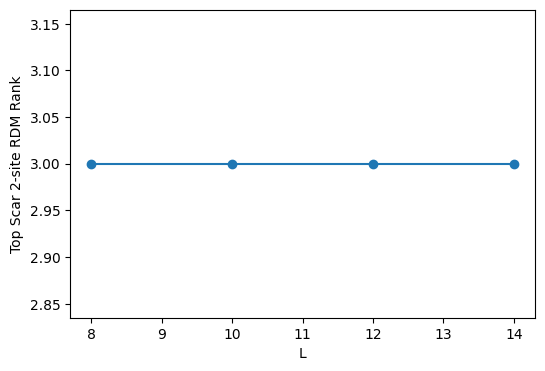

In [ ]:
# 2 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, xy_scar_2_tar, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 2-site RDM Rank')
#plt.title('XY S=1 2-sites RDM Rank vs L')
#plt.grid(True)
plt.savefig('xy_scar_2p.png', dpi=300, bbox_inches='tight')
plt.show()

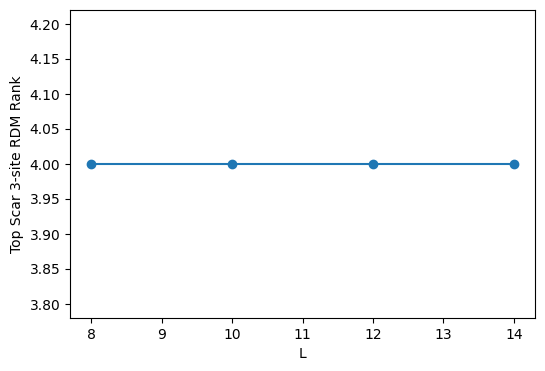

In [ ]:
# 3 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, xy_scar_3_tar, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 3-site RDM Rank')
#plt.title('XY S=1 3-sites RDM Rank vs L')
#plt.grid(True)
plt.savefig('xy_scar_3p.png', dpi=300, bbox_inches='tight')
plt.show()

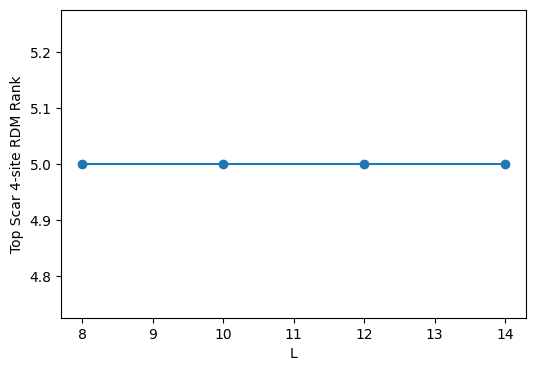

In [ ]:
# 4 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, xy_scar_4_tar, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 4-site RDM Rank')
#plt.title('XY S=1 4-sites RDM Rank vs L')
#plt.grid(True)
plt.savefig('xy_scar_4p.png', dpi=300, bbox_inches='tight')
plt.show()